本章主要内容：  
通过DistilBERT做Twitter上的情感分类问题。该模型的主要特点是用更小的模型和更高效的推断达到跟BERT相当的结果。
> 如果想要自己训练一个更大的BERT模型可以改变预训练模型的checkpoint，即加载到给定transformer的一组权重

第一次尝试使用Hugging Face生态中的Datasets, Tokenizers和Transformers
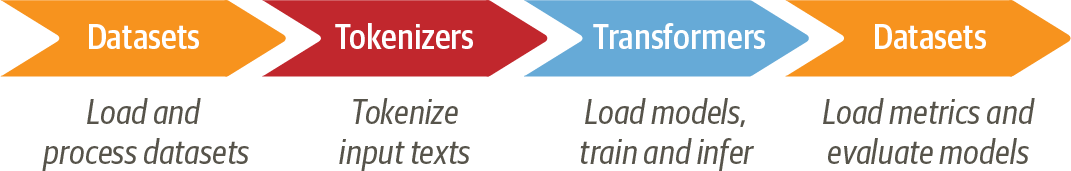

# The Dataset

* 数据集：English Twitter messages、
* 结构：有六种情绪———— anger, disgust, fear, joy, sadness, surprise

In [4]:
from transformers import pipeline

2023-03-01 10:53:58.552281: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/data/envy/anaconda3/envs/tf-gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# use list_datasets()可以查看所有Hub上可用的数据集
from datasets import list_datasets

all_datasets = list_datasets()
print(f" There are {len(all_datasets)} datasets currently available on the Hub")
print(f" The first 10 are: {all_datasets[:10]}")

 There are 23049 datasets currently available on the Hub
 The first 10 are: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [33]:
from datasets import load_dataset

emotions = load_dataset("emotion")

No config specified, defaulting to: emotion/split
Found cached dataset emotion (/data/envy/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd)


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
#查看emotions的结构，与字典很像，每个
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Hugging Face 的Datasets是基于Apache Arrow的， 比原生Python存储数据要更高效。

In [8]:
#可以跟array一样做切片和索引还有len等,但是每一行都是字典形式共存的
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [10]:
train_ds.column_names

['text', 'label']

In [11]:
print(train_ds.features)
#注意此处label名称与数字次序是一一对应的，如0是sadness

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


## 当数据集不在Hugging Face时
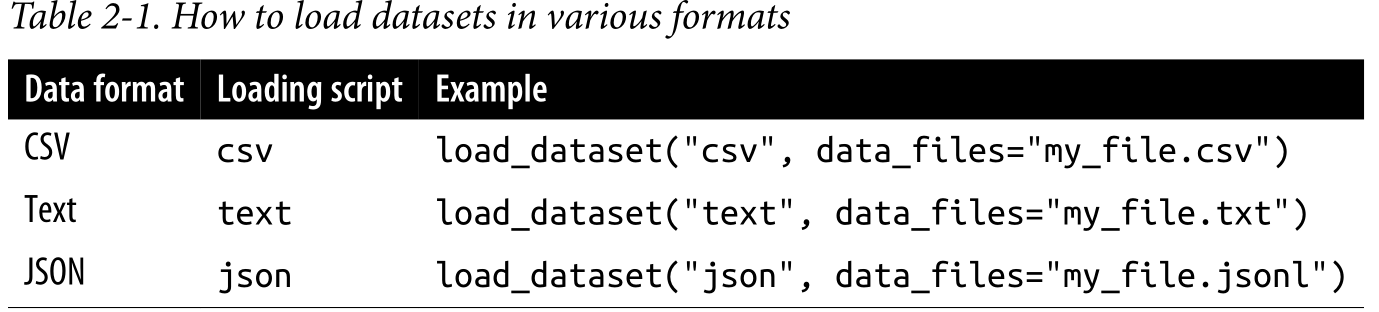

In [8]:
#也可以将Apache Arrow数据格式转变成pandas形式

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
#利用int2str将label名字添加
def label_int2str(row):
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Works before building a classifier

[A Recipe for Training Neural Networks](https://karpathy.github.io/2019/04/25/recipe/)

### 查看样本分布

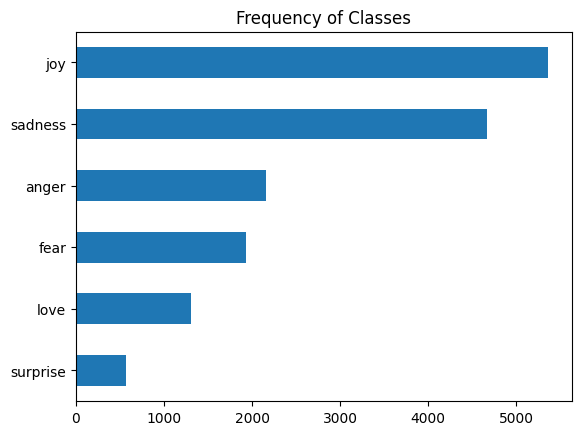

In [10]:
#建模之前先看一看每个分类的分布。可以看到love和surprise的数量比joy和sadness少了5-10倍
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

解决样本不均衡的办法：详见[Imbalanced-learn library](https://imbalanced-learn.org/stable/)
1. 随机oversample过采样小类别
2. 随机undersample降采样大类别
3. 获得更多数据

### 预览文本特征

Transformer模型对于输入序列的长度有最大的限制，被称为maximum context size.以DistilBERT为例，maximum context size是512 tokens(是每段文本中的最小单元)。此任务中我们把每个单词作为token

查看每个emotions中tweets的token平均长度。
1. 可以看到平均每个tweet15个词，最长的tweet也低于DistilBERT的maximum context size。
2. 如果长度高过这个限制的话模型会自动截断长的部分，会造成信息损失

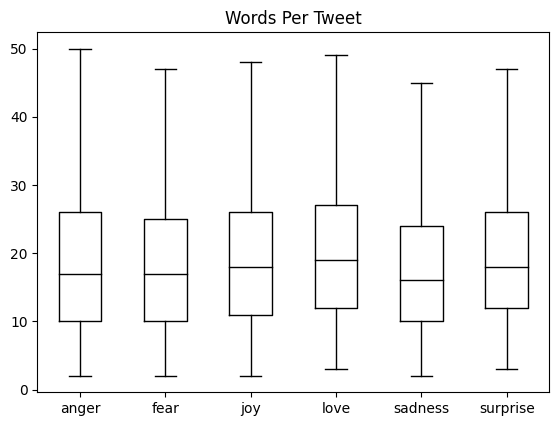

In [12]:
df['Words Per Tweet'] = df['text'].str.split().apply(len)
df.boxplot("Words Per Tweet", by = "label_name", grid = False,
           showfliers =False, color = 'black')

plt.suptitle("")
plt.xlabel("")
plt.show()

### From Text to Tokens

很多Transformer模型如DistilBERT没办法直接接收字符串，它们预设文本是已经tokenized而且encoded成为数字向量格式。

两种分词形式： character and word tokenization
1. character tokenization：按字母分词，占用参数太多，计算量消耗太大
2. word tokenization: 按照词典中存在单词进行分词，可能错失一些无法被识别的词
3. subword tokenization：集合1、2的有点的分词方法AutoTokenizer
> 一方面可以将罕见的词或者拼写错误的词，同时常出现的词被识别出来可以控制参数量级。主要用已经训练好的语料库。如WordPiece

In [13]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [ ]:
#Transformers provides a convenient AutoTokenizer class that allows you to quickly load the tokenizer associated with a pretrained model
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


In [16]:
#autotokenizer例子
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)
#这里##表示前一个词不是空格

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [18]:
#将token转化为字符串
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [19]:
tokenizer.vocab_size

30522

In [20]:
tokenizer.model_max_length

512

## Tokenizing the Whole Dataset
利用map（）方法处理DatasetDict数据

In [34]:
# 这里padding = True意味着函数会用0填充，如果batch长度没有到达模型输入上界，truncation=True代表截断，如果超过长度则截断
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation = True) 
#.tolist() 注意如果emotions被set_format改为pandas格式必须将函数改为batch['text'].tolist()

print(tokenize(emotions['train'][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


有5种特殊的token编码方式：CLS和SEP分别为文本的开头和结尾，UNK代表该token不是词典中的词“unknown”
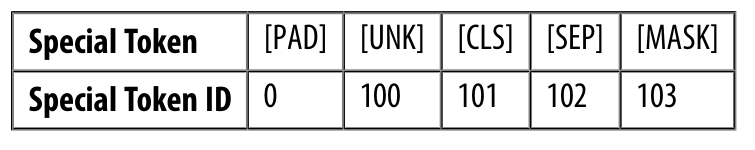

下图展示了input_ids如何被编码成token的，可以看到每个batch中，所有序列都会被填充到与最长的序列长度一致
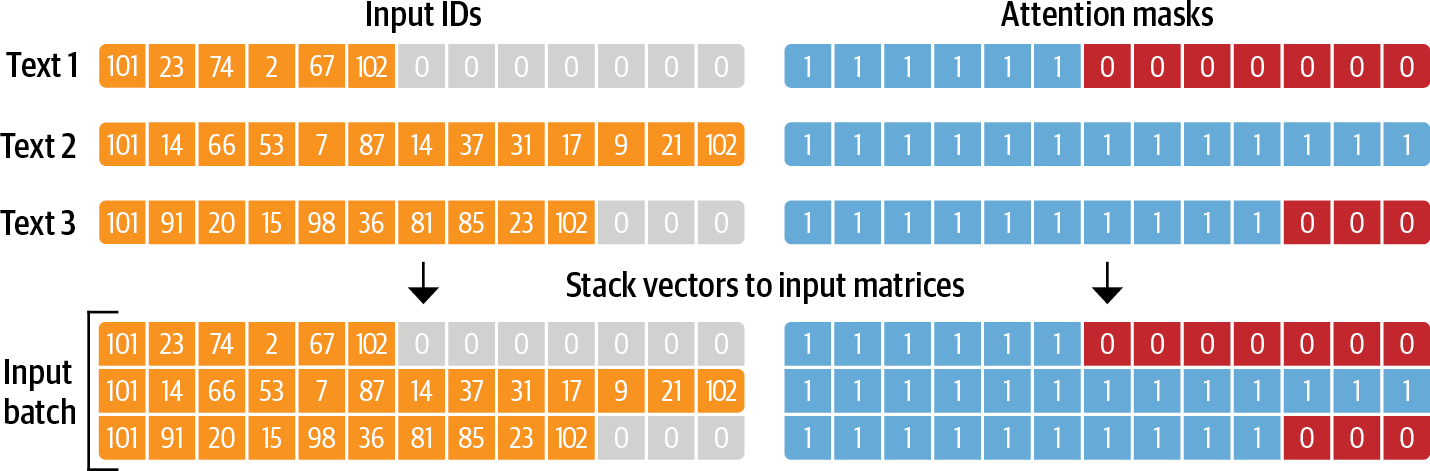

此处我们将tokenize预处理函数推广到emotions 整个语料库中，此处因为我们设置batch_size = None所以会把整个datasets当做一个batch

In [35]:
emotions_encoded = emotions.map(tokenize, batched = True, batch_size = None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

# Training a Text Classifier
先看一下DistilBERT这一encoder-based模型结构：  
1. token encoding：文本被分词并且被表征为one-hot向量（Pytorch跳过这一步骤，nn.Embedding将1,2步合并了）。通常分词器词库决定了token encoding的大小，从2w到20w独立的分词不等。
2. token embedding：将token encoding进行降维
3. Encoder stack：encoder stack通过处理token embeddings为每个输入的token生成一个hidden state
4. hidden state：
    1. 对于预训练语言模型的目标：每个隐藏状态都被馈送到预测屏蔽输入token的层
    2. 对于分类问题：把语言模型层替换为分类层
    
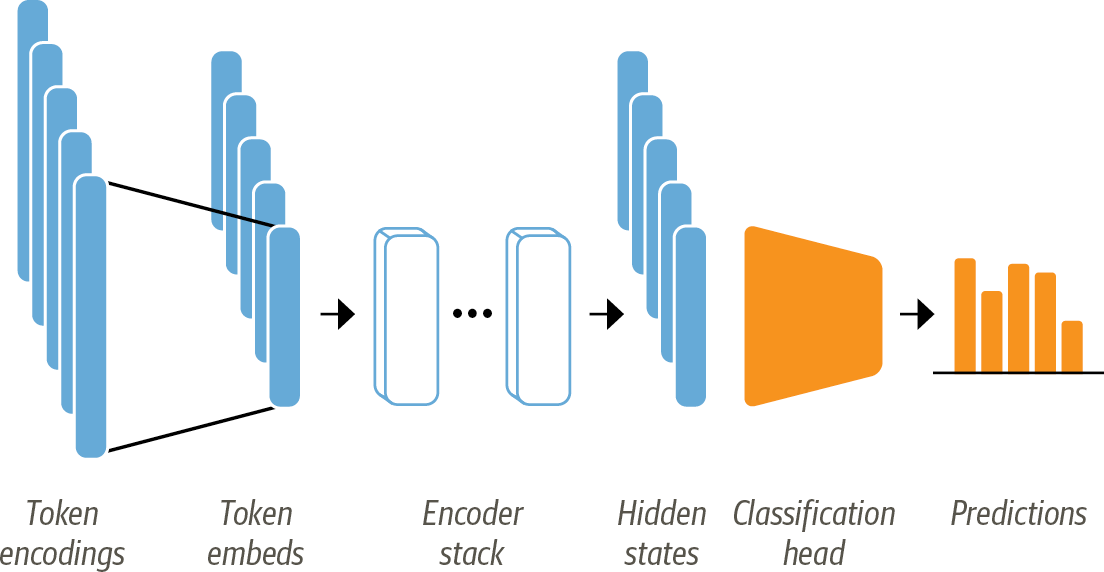

训练分类模型的两种思路：
1. 特征抽取：用隐藏状态做为特征知识用他们训练分类器，不调整预训练模型
2. Fine-tuning：从端到端训练模型，也就是说我们会更新预训练模型的参数

## Transformers as Feature Extractors
不用调整模型参数可以快速训练一个小的浅模型，这种类型的模型可以是神经网络分类层或者像是随机森林这种的不依赖梯度的方法。
> 该方法尤其适用于没有GPU的环境，因为隐藏状态仅需要呗提前计算一次  

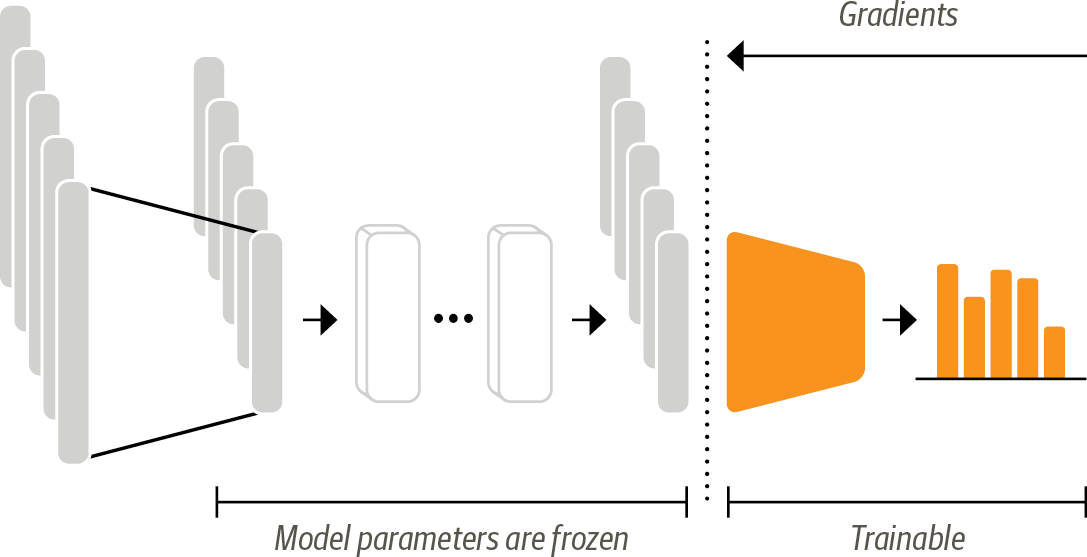

### Using Pretrained models

我们用Transofrmers另一个auto class：AutoModel。与AutoTokenizer类一样，AutoModel有一个from_pretrained()方法可以加在预训练模型的权重。

In [36]:
from transformers import AutoModel
import torch

model_ckpt = "distilbert-base-uncased"
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [38]:
torch.cuda.is_available()

True

**Transformers的可操作性**  
Transformers提供了可以在各种深度学习框架操作的可能性，如从Pytorch到Transformers还有JAX。例如此处想要加载TensorFlow框架下的DistilBERT，只需要使用一下代码  
`from transformers import TFAutoModel`    
`tf_model = TFAutoModel.from_pretrained(model_ckpt)`  

当某个模型只出现在一个框架时这一功能的作用尤为显著，如XLM-RoBERTa模型只有PyTorch的权重，如果想要加载到TensorFlow中的话，我们需要设置`from_pt = True`来下载并转换PyTorch中的权重：  
`tf_xlmr = TFAutoModel.from_pretrained("xlm-roberta-base", from_pt=True)`


In [40]:
#我们首先希望encode字符串并转化为PyTorch张量。通过设置`return_tensors='pt`即可实现
text = "this is a test"
inputs = tokenizer(text, return_tensors = "pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
#结果张量是以[batch_size, n_tokens]为形式的

Input tensor shape: torch.Size([1, 6])


In [41]:
#将这些张量传递到与模型一致的device上
inputs = {k:v.to(device) for k, v in inputs.items()}
with torch.no_grad(): #禁用自动计算梯度，这非常有助于在推断时减少内存的计算占用
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [42]:
#根据模型的设置，output可能会保存多个项目，如hidden states， losses，attentions等排列成namedtuple。
#本例子中仅返回一个attribute，即最后隐藏状态，shape是[batch_size, n_tokens, hidden_dim]
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

对分类器来说我们需要抽取出last hidden state，设计好函数后用map对DatasetDict数据逐一抽取last hidden states

In [47]:
def extract_hidden_states(batch):
    # place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {'hidden_state': last_hidden_state[:,0].cpu().numpy()}
#这里将last_hidden_state存储在cpu上以NumPy array形式存储。 因为在我们使用batched inputs时，map()方法需要我们返回Python或者Numpy objects

In [45]:
#下一步我们需要将inputs_ids attention_mask转换为torch形式
emotions_encoded.set_format("torch", columns=['input_ids', 'attention_mask', 'label'])

In [48]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [49]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

## Creating a feature matrix

In [50]:
#Use the hidden states as input features and the labels as targets
import numpy as np
X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

## Visualizing the Training set
快速预览下hidden state是否能很好的表示我们想要分类的情绪

In [62]:
import umap

from sklearn.preprocessing import MinMaxScaler

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = umap(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

TypeError: 'module' object is not callable

AttributeError: module 'umap' has no attribute 'UMAP'

## Training a simple classifier

In [67]:
from sklearn.linear_model import LogisticRegression

# We increase 'max_iter' to guarantee convergence
lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6335

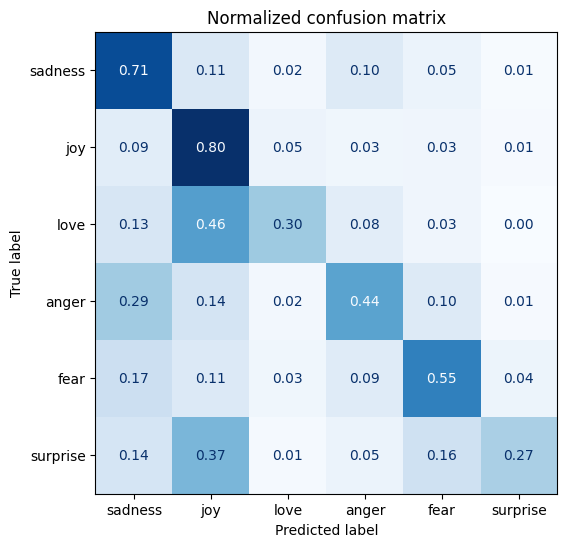

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
y_preds = lr_clf.predict(X_valid)
labels = emotions["train"].features["label"].names
plot_confusion_matrix(y_preds, y_valid, labels)

# Fine-Tuning Transformers

与仅用预训练模型做特征不同，我们要求classification head是可导的因为我们要传递梯度。这里我们用Trainer API 来简化训练过程

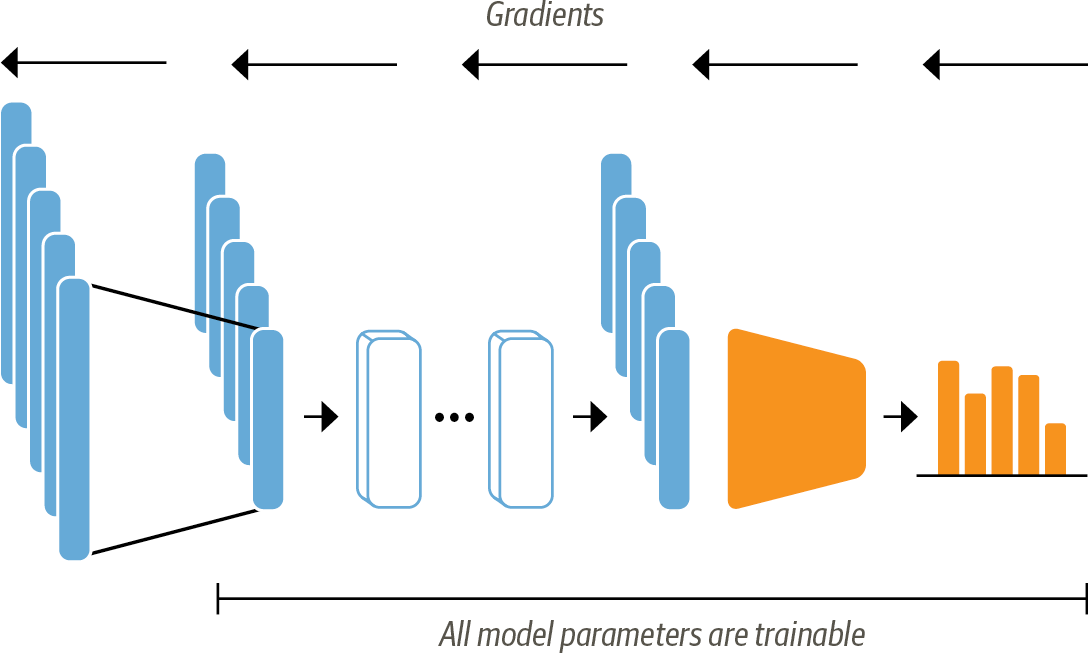

**Loading a pretrained model**

用AutoModelForSequenceClassification代替AutoModel因为它在预训练模型的输出层有一个分类head，可以非常方便的用于训练基础模型

In [71]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
        .from_pretrained(model_ckpt, num_labels=num_labels)
        .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

**Defining the performance metrics**

In [72]:
from sklearn.metrics import accuracy_score, f1_score
#计算f1 score和准确率
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

**Training the model**  
登录hugging face以便将训练好的模型公开给Hugging face community  
同时我们利用`TrainingArguments`类来定义训练参数，`output_dir`可以保存好模型的内容

In [85]:
from huggingface_hub import notebook_login

notebook_login()


In [90]:
from transformers import  TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs=2, 
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps = logging_steps, #训练日志打印到控制台的频率
                                  push_to_hub=False,  #这里如果没有sudo权限的话push_to_hub可能会出错
                                  log_level='error')

In [91]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset = emotions_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.784800,0.297990,0.909500,0.907525
2,0.236700,0.209269,0.922000,0.922124


TrainOutput(global_step=500, training_loss=0.5107479019165039, metrics={'train_runtime': 56.3628, 'train_samples_per_second': 567.751, 'train_steps_per_second': 8.871, 'total_flos': 720342861696000.0, 'train_loss': 0.5107479019165039, 'epoch': 2.0})

In [92]:
#打印confusion matrix用来直观的感受模型效果
preds_output = trainer.predict(emotions_encoded['validation'])

In [94]:
preds_output.metrics

{'test_loss': 0.20926937460899353,
 'test_accuracy': 0.922,
 'test_f1': 0.9221236953735417,
 'test_runtime': 1.0071,
 'test_samples_per_second': 1985.963,
 'test_steps_per_second': 31.775}

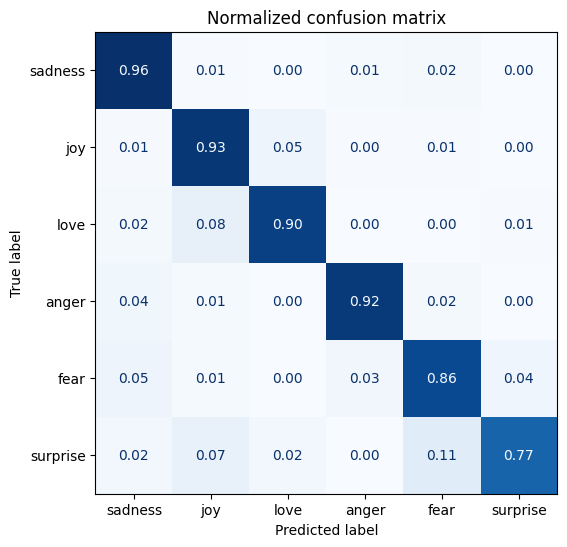

In [95]:
#用np.argmax()贪婪解码预测, 可以看到仅有joy和love会少有的出现模糊
y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

**Fine-Tuning with Keras**  
因为Keras中没有Trainer，可以用fit()方法代替

In [96]:
from transformers import TFAutoModelForSequenceClassification

tf_model = (TFAutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels))

2023-03-03 20:53:36.539408: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-03 20:53:36.554826: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-03 20:53:36.564236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 20:53:36.573683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 3090 computeCapability: 8.6
coreClock: 1.755GHz coreCount: 82 deviceMemorySize: 23.70GiB deviceMemoryBandwidth: 871.81GiB/s
2023-03-03 20:53:36.573715: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-03 20:53:36.781455: I tensorflow/stream_executor/platform/d

In [97]:
#将数据集转换为tf.data.Dataset形式，用to_tf_dataset()形式即可
# The column names to convert to TensorFlow tensors
tokenizer_columns = tokenizer.model_input_names

tf_train_dataset = emotions_encoded["train"].to_tf_dataset(
columns=tokenizer_columns, label_cols=["label"], shuffle=True,
batch_size=batch_size)

tf_eval_dataset = emotions_encoded["validation"].to_tf_dataset(
columns=tokenizer_columns, label_cols=["label"], shuffle=False,
batch_size=batch_size)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [98]:
import tensorflow as tf

tf_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=tf.metrics.SparseCategoricalAccuracy())

tf_model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=2)

2023-03-03 21:01:13.659818: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-03-03 21:01:13.689611: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2900295000 Hz


Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (o

**Error analysis**  
一个非常有效的调查模型预测结果的方法就是根据模型损失对验证集的样本排序

In [99]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 把所有张量放到与模型一致的设备上
    inputs = {k:v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis = -1)
        loss = cross_entropy(output.logits, batch['label'].to(device),
                             reduction='none')
    # 将outputs放到CPU以便于其他数据集的列兼容
    return {"loss": loss.cpu().numpy(),
            "predicted_label":pred_label.cpu().numpy()}


In [100]:
# Convert our dataset back to PyTorch tensors
emotions_encoded.set_format("torch",columns=["input_ids", "attention_mask", "label"])
# Compute loss values
emotions_encoded["validation"] = emotions_encoded["validation"].map(
               forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [101]:
#最后我们转化成DataFrame格式，包含texts, losses, 和 predicted/true labels

emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"].apply(label_int2str))

In [105]:
#看一下数据中损失最大的样本
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1274,i am going to several holiday parties and i ca...,joy,sadness,5.385217
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.220877
1801,i feel that he was being overshadowed by the s...,love,sadness,5.143198
1950,i as representative of everything thats wrong ...,surprise,sadness,5.103250
1963,i called myself pro life and voted for perry w...,joy,sadness,5.093728
1870,i guess i feel betrayed because i admired him ...,joy,sadness,4.886746
1111,im lazy my characters fall into categories of ...,joy,fear,4.617981
312,i like the domestic scene salty sweet combos r...,sadness,joy,4.560084
1590,deception from a person i loved very much,anger,love,4.533788
1836,i got a very nasty electrical shock when i was...,fear,anger,4.436883


# Saving and sharing the model

`trainer.push_to_hub(commit_message="Training completed!")上传之后就可以用`pipeline`下载和使用自己的模型

In [ ]:
from transformers import pipeline
# Change `transformersbook` to your Hub username
model_id = "transformersbook/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)